In [1]:
# Install PySpark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, expr

# Upload the dataset file
from google.colab import files
uploaded = files.upload()

# Move the uploaded file to a suitable directory
import shutil
import os

for filename in uploaded.keys():
    shutil.move(filename, "/content/" + filename)

# Initialize Spark session
spark = SparkSession.builder.appName("BostonHousingAnalysis").getOrCreate()

# Load the dataset
file_path = "/content/BostonHousing.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the schema to understand the structure
df.printSchema()

# Categorize the housing records into bins based on "RM"
bins = [0, 4, 5, 6, 7, 8, 10]
labels = ["0-4", "4-5", "5-6", "6-7", "7-8", "8-10"]

# Add a new column "RM_bin" based on the bins
df = df.withColumn("RM_bin", expr("""
    CASE
        WHEN RM >= 0 AND RM < 4 THEN '0-4'
        WHEN RM >= 4 AND RM < 5 THEN '4-5'
        WHEN RM >= 5 AND RM < 6 THEN '5-6'
        WHEN RM >= 6 AND RM < 7 THEN '6-7'
        WHEN RM >= 7 AND RM < 8 THEN '7-8'
        WHEN RM >= 8 AND RM <= 10 THEN '8-10'
        ELSE 'Other'
    END
"""))

# Calculate statistics for each bin
statistics = df.groupBy("RM_bin").agg(
    mean("MEDV").alias("mean_MEDV"),
    expr("percentile_approx(MEDV, 0.5)").alias("median_MEDV"),
    stddev("MEDV").alias("stddev_MEDV")
)

# Show the statistics
statistics.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=def493f0b2f89e3c1fb23c0af02577898615f7e2f6a84cbeda2ba252be9165ea
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Saving BostonHousing.csv to BostonHousing.csv
root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)

+------+------------------+-----------+------------------+
|RM_bin|         mean_MEDV|median_MEDV|       stddev_MEDV|
+------+------------------+-----------+------------------+
|   7-8|36.917647058823526|       35.2| 8.316362326939656|
|   4-5|16.023076923076925|       13.8|10.943959813991297|
|   5-6|17.487341772151893|       18.5| 5.352667460226968|
|   6-7| 22.01598513011151|       22.2| 6.467721594707344|
|  8-10|              44.2|       4

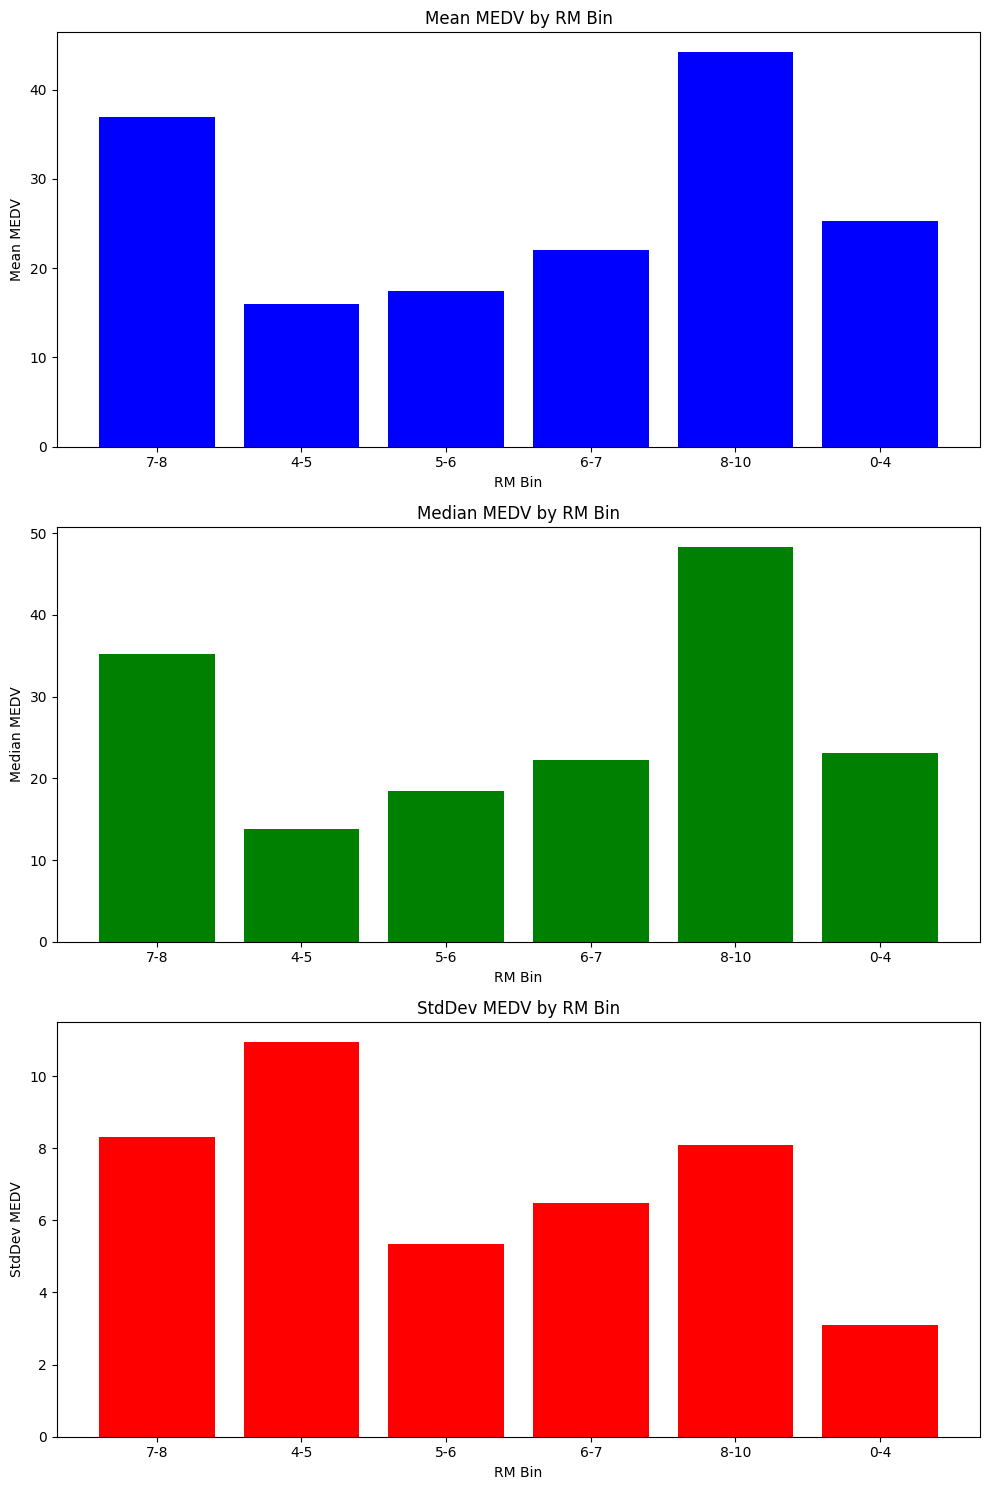

In [2]:
import matplotlib.pyplot as plt
# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
statistics_pd = statistics.toPandas()

# Plotting the statistics
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Mean MEDV plot
axes[0].bar(statistics_pd["RM_bin"], statistics_pd["mean_MEDV"], color='b')
axes[0].set_title('Mean MEDV by RM Bin')
axes[0].set_xlabel('RM Bin')
axes[0].set_ylabel('Mean MEDV')

# Median MEDV plot
axes[1].bar(statistics_pd["RM_bin"], statistics_pd["median_MEDV"], color='g')
axes[1].set_title('Median MEDV by RM Bin')
axes[1].set_xlabel('RM Bin')
axes[1].set_ylabel('Median MEDV')

# StdDev MEDV plot
axes[2].bar(statistics_pd["RM_bin"], statistics_pd["stddev_MEDV"], color='r')
axes[2].set_title('StdDev MEDV by RM Bin')
axes[2].set_xlabel('RM Bin')
axes[2].set_ylabel('StdDev MEDV')

# Adjust layout
plt.tight_layout()
plt.show()

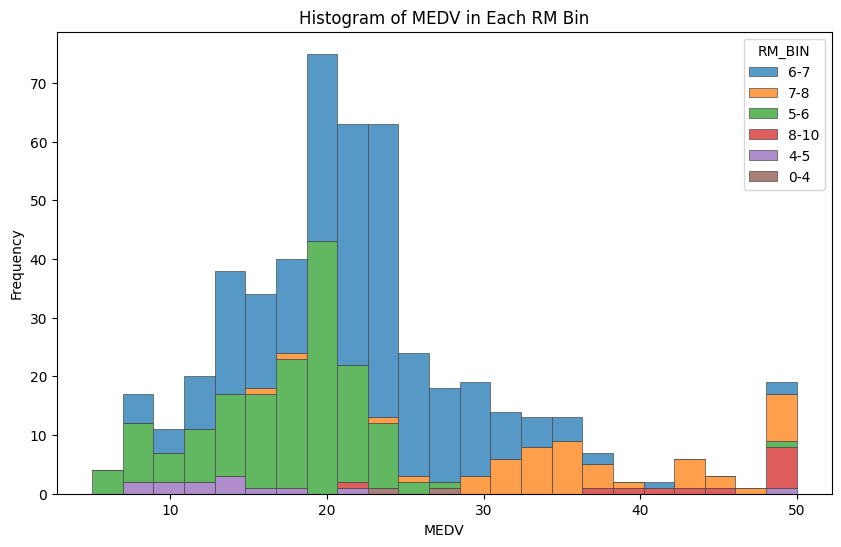

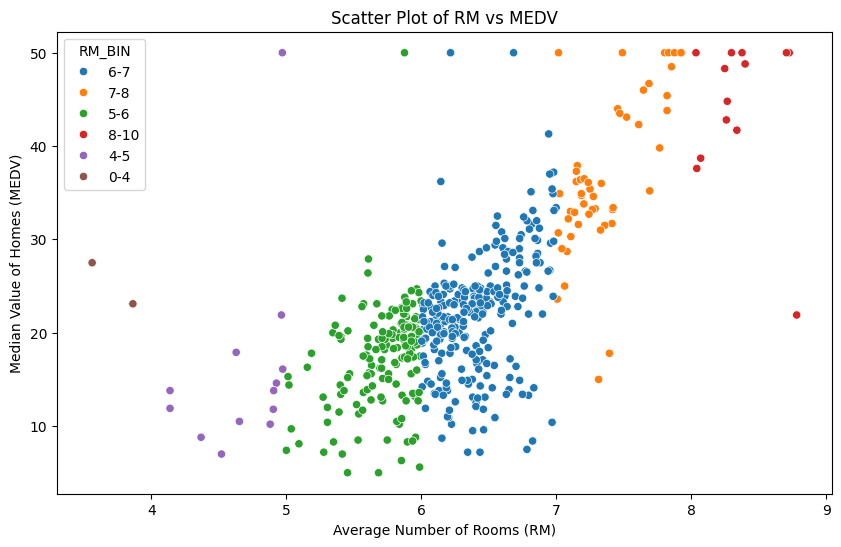

In [7]:
import seaborn as sns
# Additional Visualizations
# Convert the Spark DataFrame to a Pandas DataFrame for additional plotting
df_pd = df.toPandas()

# Ensure column names are correctly interpreted
df_pd.columns = map(str.upper, df_pd.columns)

# Histogram of MEDV in each RM bin
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_pd, x="MEDV", hue="RM_BIN", multiple="stack", palette="tab10", edgecolor=".3", linewidth=.5)
ax.set_title('Histogram of MEDV in Each RM Bin')
ax.set_xlabel('MEDV')
ax.set_ylabel('Frequency')
plt.show()

# Scatter plot of RM vs MEDV
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_pd, x="RM", y="MEDV", hue="RM_BIN", palette="tab10")
ax.set_title('Scatter Plot of RM vs MEDV')
ax.set_xlabel('Average Number of Rooms (RM)')
ax.set_ylabel('Median Value of Homes (MEDV)')
plt.show()